<a href="https://colab.research.google.com/github/NataliaDiaz/deepNLP/blob/main/1_1)_RoBERTa_Plain_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning to predict Arret prod

Based on the code by Chris McCormick and Nick Ryan. The following version was used:

*Revised on 3/20/20 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*


#Global variables

In [ ]:
Num_classes = 2
input_file_path = '/gdrive/My Drive/Colab Notebooks/Recherche/Journals/XAI for Transformers/Data/fraud_email_.csv'
random_state = 42

# Mouting GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


# Importing other useful libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import pandas as pd


## 1.2. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 2.9MB 32.0MB/s 
     |████████████████████████████████| 890kB 62.2MB/s 
     |████████████████████████████████| 1.1MB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=6161c88d48a44182959fde3c3fc9bf0394a4201922df6180ebddaa9ebd2d2790
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 2. Loading the dataset


## 2.2. Parse

In [ ]:
# Load the dataset into a pandas dataframe.
print('Loading the dataset')
df = pd.read_csv(input_file_path, delimiter=',', encoding='latin-1', header = 0)
df.dropna(inplace = True)
print(df.shape)
df.head()

Loading the dataset
(11928, 2)


,Text,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,1
1,over. SidLet me know. Thx.,0
2,"Dear Friend,Greetings to you.I wish to accost ...",1
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1
4,Not a surprising assessment from Embassy.,0


### Training and test sets

In [ ]:
from sklearn.model_selection import train_test_split

print('Generating the training and test sets')

df_training_full, df_test = train_test_split(
    df, stratify=df['Class'], test_size= 0.25, random_state = random_state)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_training_full.shape[0]))

# Display the first 5 rows from the data.
df_training_full.head(5)

Generating the training and test sets
Number of training sentences: 8,946



,Text,Class
6413,I have Gates speech but not EU.Also I think I ...,0
3345,Thx for sending. I've forwarded to Jake Sulliv...,0
5713,From=3A Mr=2E Hamad Al Nuaimi Branch Maneger N...,1
1722,k,0
10432,Err:508,1


###Validation set

In [ ]:
# Generating the validation and effective training set
print('Generating the validation and effective training set')
df_training, df_val = train_test_split(
    df_training_full, stratify=df_training_full['Class'], test_size= 0.1, random_state = random_state)

# Report the number of sentences.
print('Number of validation sentences: {:,}\n'.format(df_val.shape[0]))

# Display the first 5 rows from the data.
df_val.head(5)

Generating the validation and effective training set
Number of validation sentences: 895



,Text,Class
7128,Most observers seem confident that tomorrow wi...,0
1976,111A,0
2773,B6,0
11215,FROM=3ATHE DESK OF THE ACCOUNTANT OF ICONSHORE...,1
5023,FYI,0


###Import summary

In [ ]:
print("Data sets loaded: \n")

print('Number of training sentences: {:,}\n'.format(df_training.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_val.shape[0]))
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

Data sets loaded: 

Number of training sentences: 8,051

Number of validation sentences: 895

Number of test sentences: 2,982



##2.3. Preprocessing and extracting the features

###Training set

In [ ]:
# Get the arrays of sentences and their labels.
sentences_train = df_training['Text'].values
print('Example sentence: ', sentences_train[0])
labels_train = df_training['Class'].values
print('Example label: ', labels_train[0])
print('Distribution of classes: \n')
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

Example sentence:  DEAREST, I sincerely write to seek your co-operation and trusts to enable me carry out an urgent business opportunity in my Legal Firm. I am Barrister Daniel Martins,a lawyer/fund Advisor to Gtb bank Abuja.with some bank officials, It will be in our interest to transfer this fund worth $20,000,000 million dollars in an account offshore. If you can be a collaborator/partner to this please indicate interest immediately for us to proceed.Your contact phone numbers and name will be necessary for this effect,I have reposed my confidence in you and hope that you will not disappoint me.as i had deposited this money as a consignement belonging to foreign partner with the security company in Europe,What I am demanding from you now is to arrange to visit the Security company where this money is being deposited and claim it as the bona-fide owner.My Regards,Daniel Martins{esq]
Example label:  1
Distribution of classes: 



{0: 4550, 1: 3501}

###Validation set

In [ ]:
# Get the arrays of sentences and their labels.
sentences_val = df_val['Text'].values
print('Example sentence: ', sentences_val[0])

# Only use transform and not fit_trainsform for this one
labels_val = df_val['Class'].values
print('Example label: ', labels_val[0])
print('Distribution of classes: \n')
unique, counts = np.unique(labels_val, return_counts=True)
dict(zip(unique, counts))

Example sentence:  Most observers seem confident that tomorrow will go smoothly. Shaun has indicated that he'd like to speak with youlate morning or early afternoon. I'll check back in tomorrow am.
Example label:  0
Distribution of classes: 



{0: 506, 1: 389}

###Test set

In [ ]:
# Get the arrays of sentences and their labels.
sentences_test = df_test['Text'].values
print('Example sentence: ', sentences_test[0])

# Only use transform and not fit_trainsform for this one
labels_test = df_test['Class'].values
print('Example label: ', labels_test[0])
print('Distribution of classes: \n')
unique, counts = np.unique(labels_test, return_counts=True)
dict(zip(unique, counts))

Example sentence:  I think Jake should be on the call.Once the call is scheduled I will get a version to you before the call that reflects the latest revisions I'vereceived.DanOn Sun Dec 13 2009 at 7:56 AM H <HDR22@clintonemai1.com> wrote:The latest draft is getting closer. And I agree w Dan that we have to be careful not to topple the tree w toomany ornaments. That said I'd like to have a call w you (and anyone else who you think should be on) thisafternoon or evening to raise a few points. I'm copying Lona and Huma so they can help schedule it. Thanksfor all your good work.
Example label:  0
Distribution of classes: 



{0: 1686, 1: 1296}

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. RoBERTa Tokenizer

In [ ]:
from transformers import RobertaTokenizer

# Load the RoBERTa tokenizer
print('Loading RoBERTa tokenizer...')
# Using 'roberta-base': https://huggingface.co/transformers/pretrained_models.html
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case = True)

Loading RoBERTa tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  DEAREST, I sincerely write to seek your co-operation and trusts to enable me carry out an urgent business opportunity in my Legal Firm. I am Barrister Daniel Martins,a lawyer/fund Advisor to Gtb bank Abuja.with some bank officials, It will be in our interest to transfer this fund worth $20,000,000 million dollars in an account offshore. If you can be a collaborator/partner to this please indicate interest immediately for us to proceed.Your contact phone numbers and name will be necessary for this effect,I have reposed my confidence in you and hope that you will not disappoint me.as i had deposited this money as a consignement belonging to foreign partner with the security company in Europe,What I am demanding from you now is to arrange to visit the Security company where this money is being deposited and claim it as the bona-fide owner.My Regards,Daniel Martins{esq]
Tokenized:  ['DE', 'AR', 'EST', ',', 'ĠI', 'Ġsincerely', 'Ġwrite', 'Ġto', 'Ġseek', 'Ġyour', 'Ġco', '-', 'oper

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

### Picking the max lenght with the training set

In [ ]:
df['Sentence_length'] = df['Text'].apply(lambda x : int(len(tokenizer.tokenize(x))))

In [ ]:
df['Sentence_length'].describe()

count    11928.000000
mean       398.333082
std       1815.619439
min          0.000000
25%         17.000000
50%         77.000000
75%        533.000000
max      68639.000000
Name: Sentence_length, dtype: float64

Text(0.5, 1.0, 'Histogram for input sequence length')

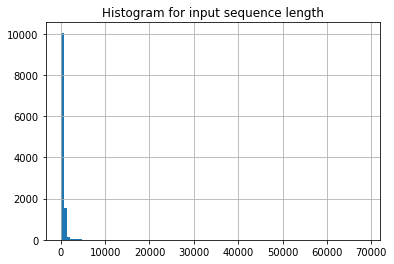

In [ ]:
df['Sentence_length'].hist(bins = 100)
plt.title('Histogram for input sequence length')

In [ ]:
df['Sentence_length'].quantile([0.68, .9, .95])

0.68     405.0
0.90     830.0
0.95    1079.0
Name: Sentence_length, dtype: float64

### Creating a function to tokenize

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
def Tokenizer_wrapper(sentences, labels):
  '''
  Input: {sentences to be tokenized as a numpy array. This tokenizes,
        adds [CLS] and [SEP], maps the token to the IDs, PAD to the max lenght,
        and create attention masks for the [PAD] token/ labels: the labels as a numpy array
        that will only be transformed into a torch tensor}
  Output: three torch tensors: input_ids, attention_masks, labels
  '''
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 256,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation = True
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

### Tokenizing the trainig set

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
# Tokenizing
input_ids_train, attention_masks_train, labels_train = Tokenizer_wrapper(sentences_train, labels_train)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  DEAREST, I sincerely write to seek your co-operation and trusts to enable me carry out an urgent business opportunity in my Legal Firm. I am Barrister Daniel Martins,a lawyer/fund Advisor to Gtb bank Abuja.with some bank officials, It will be in our interest to transfer this fund worth $20,000,000 million dollars in an account offshore. If you can be a collaborator/partner to this please indicate interest immediately for us to proceed.Your contact phone numbers and name will be necessary for this effect,I have reposed my confidence in you and hope that you will not disappoint me.as i had deposited this money as a consignement belonging to foreign partner with the security company in Europe,What I am demanding from you now is to arrange to visit the Security company where this money is being deposited and claim it as the bona-fide owner.My Regards,Daniel Martins{esq]
Token IDs: tensor([    0, 10089,  2747,  4923,     6,    38, 24740,  3116,     7,  2639,
          110,  1029,

In [ ]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)

### Tokenizing the validation set

In [ ]:
# Tokenizing
input_ids_val, attention_masks_val, labels_val = Tokenizer_wrapper(sentences_val, labels_val)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Most observers seem confident that tomorrow will go smoothly. Shaun has indicated that he'd like to speak with youlate morning or early afternoon. I'll check back in tomorrow am.
Token IDs: tensor([    0,  2895, 12136,  2045,  3230,    14,  3859,    40,   213, 17359,
            4, 16065,    34,  4658,    14,    37,  1017,   101,     7,  1994,
           19,    47, 19593,   662,    50,   419,  1390,     4,    38,   581,
         1649,   124,    11,  3859,   524,     4,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     

In [ ]:
# Combine the training inputs into a TensorDataset.
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### Tokenizing the test set

In [ ]:
# Tokenizing
input_ids_test, attention_masks_test, labels_test = Tokenizer_wrapper(sentences_test, labels_test)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I think Jake should be on the call.Once the call is scheduled I will get a version to you before the call that reflects the latest revisions I'vereceived.DanOn Sun Dec 13 2009 at 7:56 AM H <HDR22@clintonemai1.com> wrote:The latest draft is getting closer. And I agree w Dan that we have to be careful not to topple the tree w toomany ornaments. That said I'd like to have a call w you (and anyone else who you think should be on) thisafternoon or evening to raise a few points. I'm copying Lona and Huma so they can help schedule it. Thanksfor all your good work.
Token IDs: tensor([    0,   100,   206,  6469,   197,    28,    15,     5,   486,     4,
        11475,     5,   486,    16,  1768,    38,    40,   120,    10,  1732,
            7,    47,   137,     5,   486,    14,  6771,     5,   665, 24084,
           38,   348, 33979,     4, 25887,  4148,  2083,  1502,   508,  2338,
           23,   262,    35,  4419,  3326,   289, 28696,   725, 10644,  2036,
         1039, 45397,   

In [ ]:
# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

### Creating iterators for the training, validation, and test sets

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For test the order doesn't matter, so we'll just read them sequentially.
# prediction_dataloader = is the test data loader (named changed to be compliant with this code)
prediction_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. RobertaForSequenceClassification

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

# Load RobertaForSequenceClassification, RoBERTa Model transformer with a 
# sequence classification/regression 
# head on top (a linear layer on top of the pooled output) e.g. for GLUE tasks.

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", #12-layer RoBERTa model
    num_labels = Num_classes, # Number of predicted classes
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
) 
   
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random
import numpy as np
import os

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

Total_training_time = time.time()-total_t0
print("Total training took {:} (h:mm:ss)".format(format_time(Total_training_time)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    504.    Elapsed: 0:00:10.
  Batch    80  of    504.    Elapsed: 0:00:19.
  Batch   120  of    504.    Elapsed: 0:00:29.
  Batch   160  of    504.    Elapsed: 0:00:39.
  Batch   200  of    504.    Elapsed: 0:00:48.
  Batch   240  of    504.    Elapsed: 0:00:58.
  Batch   280  of    504.    Elapsed: 0:01:07.
  Batch   320  of    504.    Elapsed: 0:01:17.
  Batch   360  of    504.    Elapsed: 0:01:26.
  Batch   400  of    504.    Elapsed: 0:01:36.
  Batch   440  of    504.    Elapsed: 0:01:45.
  Batch   480  of    504.    Elapsed: 0:01:55.

  Average training loss: 0.05
  Training epcoh took: 0:02:00

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:04

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    504.    Elapsed: 0:00:10.
  Batch    80  of    504.    Elapsed: 0:00:19.
  Batch   120  of    504.    Elapsed: 0:00:29.
  Batch   160  of    504.    Elapsed: 0:00:38.
  Batch  

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,5.48e-02,0.06,0.99,0:02:00,0:00:04
2,1.01e-02,0.01,1.00,0:01:59,0:00:04
3,2.98e-03,0.03,0.99,0:01:59,0:00:04


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

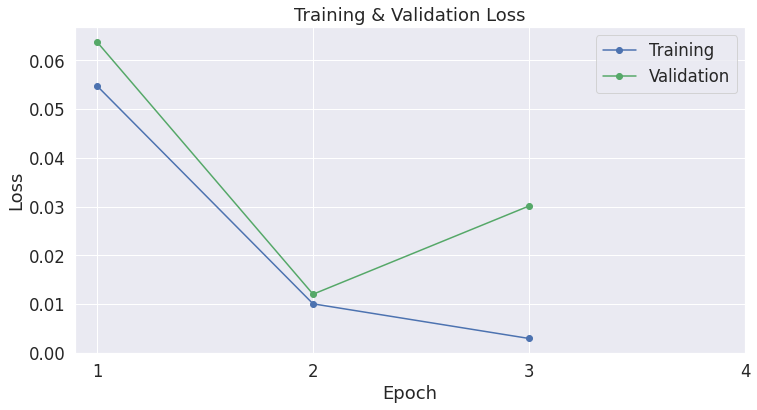

In [ ]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Validation Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_val)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 895 test sentences...
    DONE.


Accuracy measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 


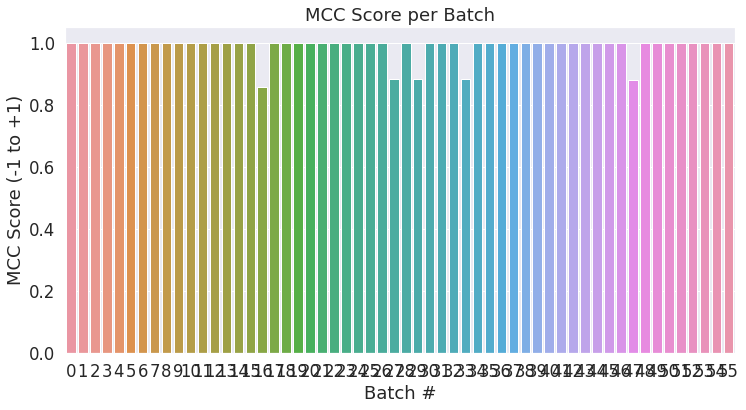

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.989


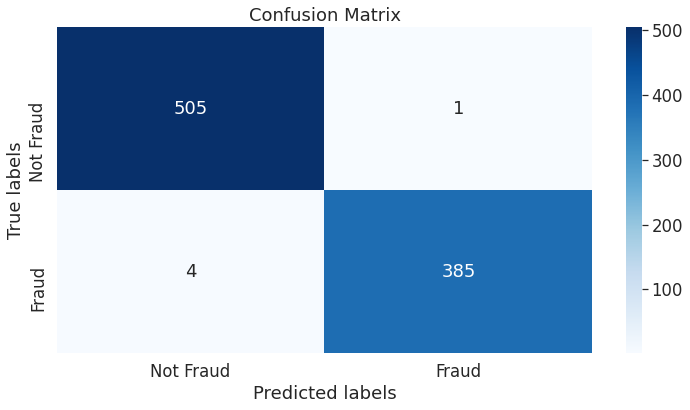

In [ ]:
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

#conf_mx = np.round_(confusion_matrix(flat_true_labels, flat_predictions, normalize='all')*100, decimals=2)
conf_mx = confusion_matrix(flat_true_labels, flat_predictions)

import seaborn as sns

ax= plt.subplot()
sns.heatmap(conf_mx, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

In [ ]:
from sklearn.metrics import recall_score, f1_score, matthews_corrcoef

good_preds = 0
for i in range(len(flat_predictions)):
  if (flat_predictions[i] == flat_true_labels[i]) == True:
    good_preds += 1

accuracy = good_preds/len(flat_predictions)

print('Accuracy: ', accuracy)
# 0 label is our positive label (Not fraud)
print('Sensitivity: ', recall_score(flat_true_labels, flat_predictions, pos_label = 0))
# 1 label is our negative label (Fraud)
print('Specificity: ', recall_score(flat_true_labels, flat_predictions, pos_label = 1))
print('F1 score: ', f1_score(flat_true_labels, flat_predictions))
print('Matthews Cor. Coef.: ', matthews_corrcoef(flat_true_labels, flat_predictions))
print('Total training time: ', Total_training_time)

Accuracy:  0.994413407821229
Sensitivity:  0.9980237154150198
Specificity:  0.9897172236503856
F1 score:  0.9935483870967742
Matthews Cor. Coef.:  0.9886454455176936
Total training time:  370.5785984992981


# 6. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,982 test sentences...
    DONE.


Accuracy measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 


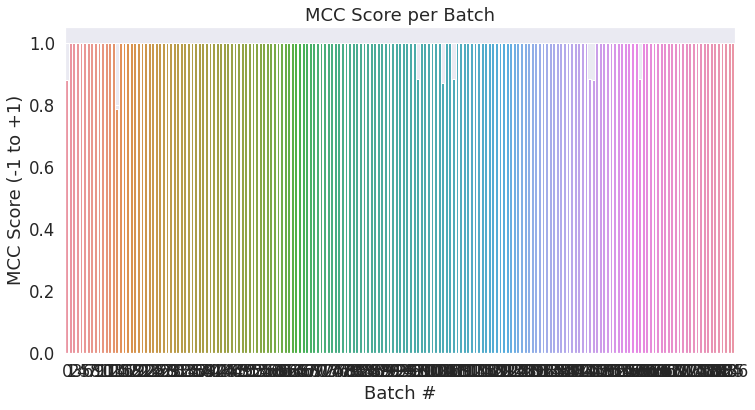

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.995


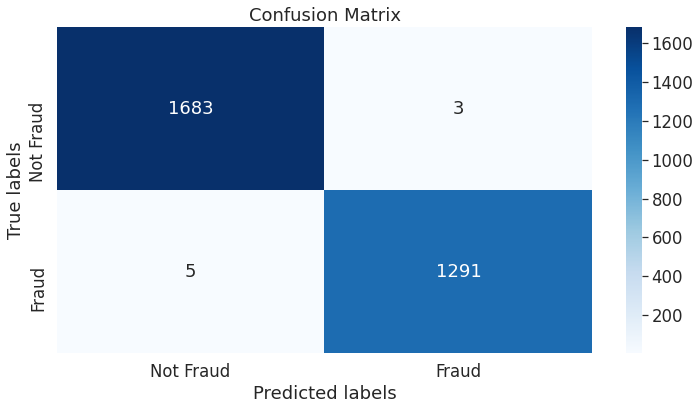

In [ ]:
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

#conf_mx = np.round_(confusion_matrix(flat_true_labels, flat_predictions, normalize='all')*100, decimals=2)
conf_mx = confusion_matrix(flat_true_labels, flat_predictions)

import seaborn as sns

ax= plt.subplot()
sns.heatmap(conf_mx, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

In [ ]:
from sklearn.metrics import recall_score, f1_score, matthews_corrcoef

good_preds = 0
for i in range(len(flat_predictions)):
  if (flat_predictions[i] == flat_true_labels[i]) == True:
    good_preds += 1

accuracy = good_preds/len(flat_predictions)

print('Accuracy: ', accuracy)
# 0 label is our positive label (Not fraud)
print('Sensitivity: ', recall_score(flat_true_labels, flat_predictions, pos_label = 0))
# 1 label is our negative label (Fraud)
print('Specificity: ', recall_score(flat_true_labels, flat_predictions, pos_label = 1))
print('F1 score: ', f1_score(flat_true_labels, flat_predictions))
print('Matthews Cor. Coef.: ', matthews_corrcoef(flat_true_labels, flat_predictions))
print('Total training time: ', Total_training_time)

Accuracy:  0.9973172367538564
Sensitivity:  0.998220640569395
Specificity:  0.996141975308642
F1 score:  0.996911196911197
Matthews Cor. Coef.:  0.9945410529842622
Total training time:  370.5785984992981


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
# import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './model_save/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Let's check out the file sizes, out of curiosity.

In [ ]:
# !ls -l --block-size=K ./model_save/

The largest file is the model weights, at around 418 megabytes.

In [ ]:
# !ls -l --block-size=M ./model_save/pytorch_model.bin

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# # Mount Google Drive to this Notebook instance.
# from google.colab import drive
#     drive.mount('/content/drive')

In [ ]:
# # Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# # Copy the model to the GPU.
# model.to(device)

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# # This code is taken from:
# # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# # Don't apply weight decay to any parameters whose names include these tokens.
# # (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
# no_decay = ['bias', 'LayerNorm.weight']

# # Separate the `weight` parameters from the `bias` parameters. 
# # - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# # - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
# optimizer_grouped_parameters = [
#     # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.1},
    
#     # Filter for parameters which *do* include those.
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]

# # Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# # the names.

# Revision History

**Version 3** - *Mar 18th, 2020* - (current)
* Simplified the tokenization and input formatting (for both training and test) by leveraging the `tokenizer.encode_plus` function. 
`encode_plus` handles padding *and* creates the attention masks for us.
* Improved explanation of attention masks.
* Switched to using `torch.utils.data.random_split` for creating the training-validation split.
* Added a summary table of the training statistics (validation loss, time per epoch, etc.).
* Added validation loss to the learning curve plot, so we can see if we're overfitting. 
    * Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing this!
* Displayed the per-batch MCC as a bar plot.

**Version 2** - *Dec 20th, 2019* - [link](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP)
* huggingface renamed their library to `transformers`. 
* Updated the notebook to use the `transformers` library.

**Version 1** - *July 22nd, 2019*
* Initial version.

## Further Work

* It might make more sense to use the MCC score for “validation accuracy”, but I’ve left it out so as not to have to explain it earlier in the Notebook.
* Seeding -- I’m not convinced that setting the seed values at the beginning of the training loop is actually creating reproducible results…
* The MCC score seems to vary substantially across different runs. It would be interesting to run this example a number of times and show the variance.
